In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import (StratifiedKFold, cross_val_score, learning_curve, GridSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import (AdaBoostClassifier, RandomForestClassifier,
                              ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier)
%matplotlib inline

In [2]:
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")
IDtest = data_test['PassengerId']

In [3]:
# попробуем обнаружить выбросы в данных, используя метод Тьюки

def detect_outliers(df, n, features):
    outlier_indices = []
    # итерируемся по фичам
    for col in features:
        # 1-й квартиль (25%)
        q1 = np.percentile(df[col], 25)
        # 3-й квартиль (75%)
        q3 = np.percentile(df[col],75)
        # межквартильный размах (IQR)
        iqr = q3 - q1
        outlier_step = 1.5 * iqr
        # создадим список индексов выбросов для признака col
        outlier_list_col = df[(df[col] < q1 - outlier_step) | (df[col] > q3 + outlier_step )].index
        outlier_indices.extend(outlier_list_col)
    # отбор индексов по количеству выбросов
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers

# подсчитаем выбросы для столбцов Age, SibSp , Parch и Fare
outliers_to_drop = detect_outliers(data_train, 2, ["Age","SibSp","Parch","Fare"])

In [4]:
data_train.loc[outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S


Обнаружено 10 записей с аномальными значениями (выбросами). У троих пассажиров наблюдается высокая стоимость билетов Fare,
у семерых пассажирова большое значение SibSp.

In [5]:
data_train = data_train.drop(outliers_to_drop, axis = 0).reset_index(drop=True)

In [6]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
len_train = len(data_train)
dataset =  pd.concat(objs=[data_train, data_test], axis=0, sort=False).reset_index(drop=True)

Колонка Survived(выжил) - это целевая переменная. Если Survived=1, то пассажир выжил, в противном слочае - утонул.

Остальные колонки являются независимыми переменными (признаки, фичи):
* PassengerId - уникальный идентификатор пассажира корабля (числовое значение)
* Pclass - класс пассажира. Возможные значения: 1, 2, 3 (первый, второй, третий классы) (числовое значение)
* Name - имя пассажира (строковое значение)
* Sex - пол (категориальный признак)
* Age - возраст (число)
* SibSp - количество братьев, сестер и супругов,путешествующих с пассажирами (числвое значение)
* Parch - количество родителей и детей, путешествующих с пассажиром (числовое значение)
* Ticket - номер билета (строка)
* Fare - стоимость билета (числовой признак)
* Cabin - номер кабины пассажира (строка)
* Embarked - пункт отправления пассажира. Возможные значения: S, C, Q ("Cherbourg", "Queenstown", "Southampton", категориальный признак)

Numeric values: 'Age','SibSp','Parch','Fare'

Categorical values: 'Survived','Pclass','Sex','Ticket','Cabin','Embarked'

In [8]:
data_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


В таблице выше прдставлены некоторые основные статистические показатели по числовым переменным. Заметим, что столбец Age имеет 170 пропущенных значений. 

In [10]:
dataset.isnull().sum()
dataset.shape

(1299, 12)

Видим, что в колонке Age пропущено 256 значений, что приблизительно состовляет 20% от общего количества пассажиров. В колонке Cabin - 1007 (77%). Embarked - 2 значения.
Если по возрастам Age мы можем заполнить пропуски (например средними значениями), то пропуски Cabin восполнить труднее, т.к. слишком большая доля пропущенных значений. По поводу Embarked - невозможно определить, в каком городе пассажир сел на корабль.

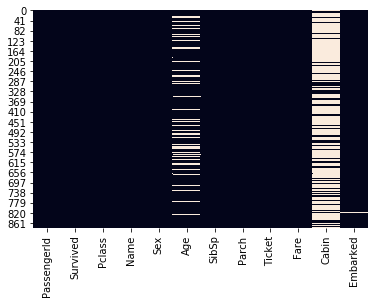

In [10]:
sns.heatmap(data_train.isnull(), cbar=False)

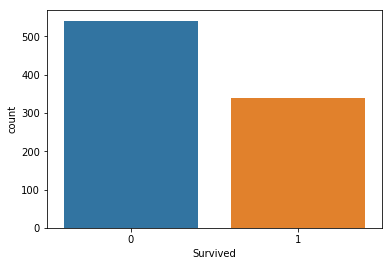

In [11]:
sns.countplot(data=data_train, x='Survived')

На графике выше отображено количество выживших и погибших. Погибших, видно, больше. Классы более менее сбалансированны.

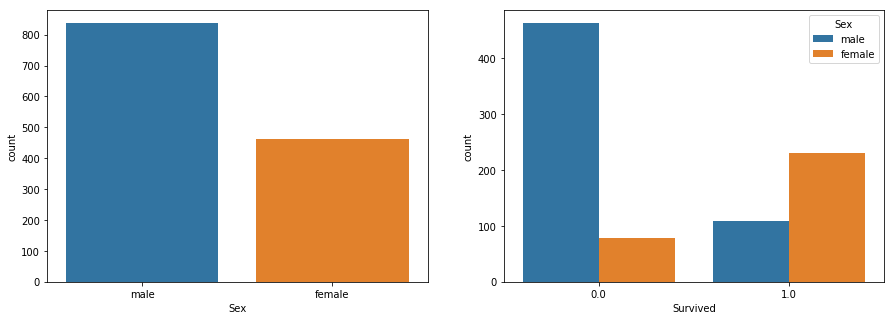

In [21]:
_, axs = plt.subplots(ncols=2, figsize=(15, 5))
sns.countplot(data=dataset, x='Sex', ax=axs[0])
sns.countplot(data=dataset,x='Survived',hue='Sex', ax=axs[1])

Всего мужчин было больше. Видим, что среди погибших было больше мужчин. Среди выживших - женщин, что не удивително, так как была команда спасти, в первую очередь, женщин и детей.

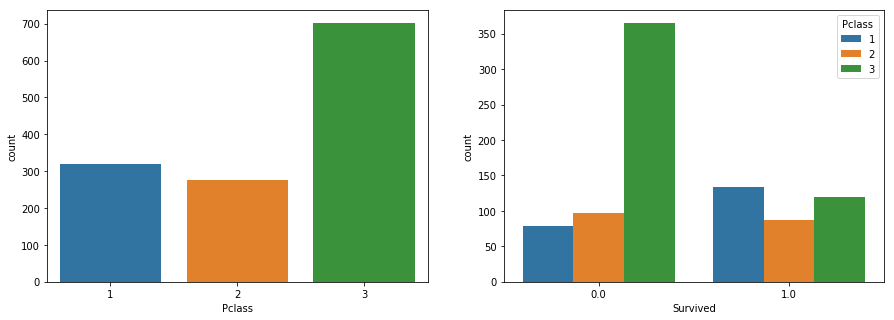

In [24]:
_, axs = plt.subplots(ncols=2, figsize=(15, 5))
sns.countplot(data=dataset, x='Pclass', ax=axs[0])
sns.countplot(data=dataset, x='Survived', hue='Pclass', ax=axs[1])

Пассажирова 3 класса было больше всего. На графике выше можем заметить, что среди погибших большинство пассажиров из третьего класса. Среди выживших ситуация иная - первый класс оказался более живучим, что не удивительно, так как их каюты, скорее всего, были расположены выше (ближе) к палубе, соответственно времени добраться до спасательных лодок необходимо меньше.

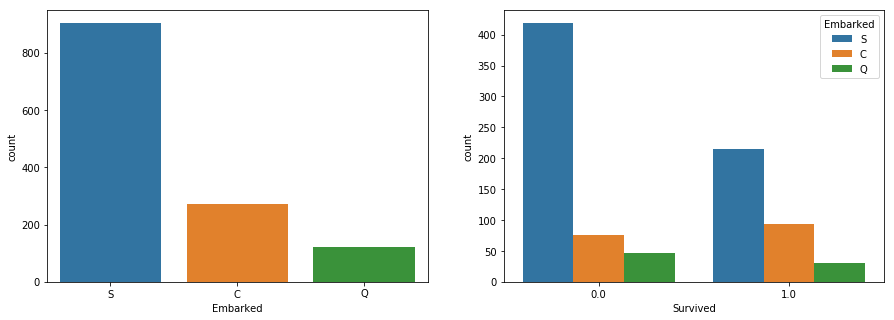

In [27]:
_, axs = plt.subplots(ncols=2, figsize=(15, 5))
sns.countplot(data=dataset, x='Embarked', ax=axs[0])
sns.countplot(data=dataset, x='Survived', hue='Embarked', ax=axs[1])

C: "Cherbourg",
Q: "Queenstown",
S: "Southampton"

Видно, что большая часть пассажиров отправилась из города Southampton (S). Среди погибших и выживших так же основная часть из города S.
Заменим 2 пропущенных значения Embarked на S.

In [28]:
dataset.loc[dataset.Embarked.isna(), 'Embarked'] = 'S'

Самому младшему пассажиру 0.42 лет.
Самому старшему пассажиру 80.0 лет.


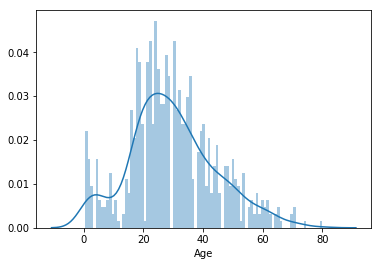

In [29]:
# data_train.Age.value_counts()
# data_train.hist(column='Age', grid=False, bins=50)
sns.distplot(data_train['Age'], bins=len(data_train.Age.unique()))
print('Самому младшему пассажиру {age} лет.'.format(age=data_train.Age.min()))
print('Самому старшему пассажиру {age} лет.'.format(age=data_train.Age.max()))

Распределение пассажиров по возрастам. Видим, что основная доля пассажиров в возрасте от 15 до 40 лет.


Самый дешевый билет стоил 4.0125
Самый дорогой билет стоил 512.3292


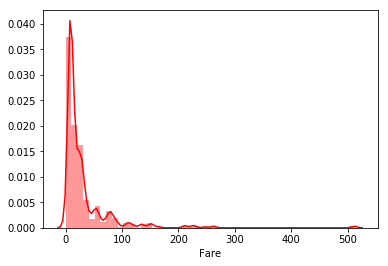

In [30]:
# data_train.Fare.value_counts()
# data_train.hist(column='Fare', grid=False, bins=50)
sns.distplot(data_train['Fare'], bins=50, color='r')
print('Самый дешевый билет стоил {fare}'.format(fare=data_train.Fare[data_train.Fare > 0.].min()))  # > 0 потому что есть значения 0 (возможно дети или экипаж корабля)
print('Самый дорогой билет стоил {fare}'.format(fare=data_train.Fare.max()))

Распределение стоимости билетов. Видим, что основная доля пассажиров со стоимостью билета в диапазоне 0<Fare<100.

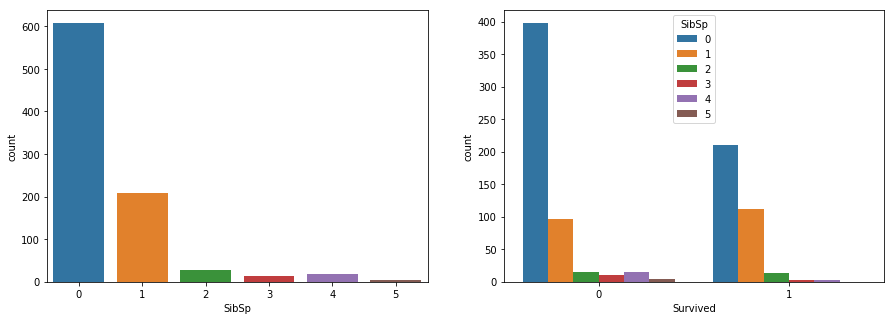

In [31]:
# data_train.SibSp.hist(grid=False)
_, axs = plt.subplots(ncols=2, figsize=(15, 5))
sns.countplot(data=data_train, x='SibSp', ax=axs[0])
sns.countplot(data=data_train, x='Survived', hue='SibSp', ax=axs[1])

Распределение пассажиров по по сумме 'супруг + братья и сёстры на борту корабля'

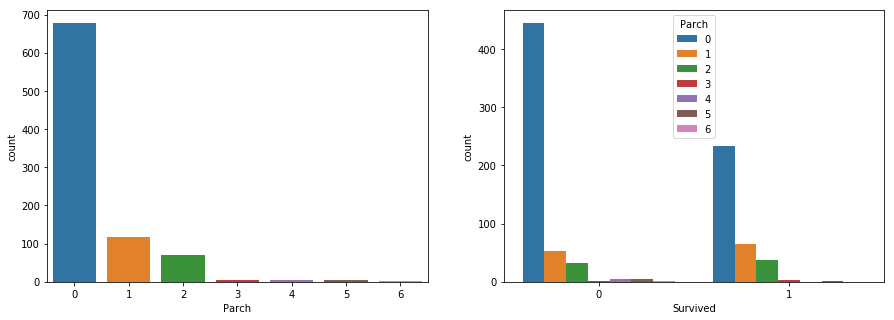

In [32]:
# data_train.Parch.hist(grid=False)
_, axs = plt.subplots(ncols=2, figsize=(15, 5))
sns.countplot(data=data_train, x='Parch', ax=axs[0])
sns.countplot(data=data_train, x='Survived', hue='Parch', ax=axs[1])

Распределение пассажиров по сумме 'родители + дети на борту'

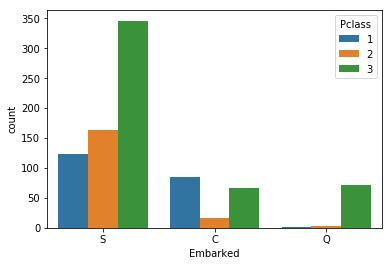

In [34]:
sns.countplot(data=data_train, x='Embarked', hue='Pclass')

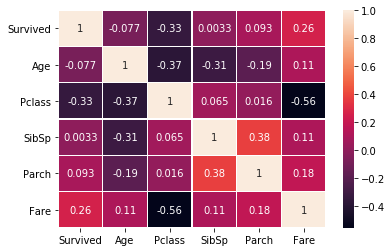

In [35]:
sns.heatmap(data_train[['Survived', 'Age', 'Pclass', 'SibSp', 'Parch', 'Fare']].corr(),annot=True,linewidth=0.2)

Матрица корреляций подтверждает некоторые предположения из инфографики выше. А
именно - что между возрастом и классом существует отрицательная корреляция, что,
скорее всего, связано с тем, что более возрастные пассажиры чаще могли себе позволить более дорогую каюту.
Кроме того, стоимость билета и класс тесно связаны (высокий коэффициент корреляции), что вполне ожидаемо.
Другие признаки слабо влияют на целевую переменную (малое значение корреляции), но это ещё не означает, что их нужно
убирать из набора, поскольку они могут влиять на целевую переменную косвенно и даже в связке с другими признаками.

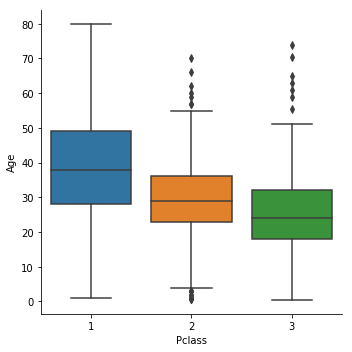

In [22]:
sns.catplot(data=data_train, y='Age', x='Pclass', kind='box')

Чем старше человек — тем его вероятное благосостояние выше и, соответственно, выше и тот уровень комфорта, который он может себе позволить. Что нам это дает? Можем заменить пропущенное значение Age для пассажира, например из третьего класса, средним возрастом для этого класса. Это уже лучше, чем просто заменять пропущенные значения Age просто средним по всем пассажирам.
Можно проверить ещё один вариант замены пропущенных значений Age, используя столбец с именами Name.

In [36]:
data_train.Name.head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

Имя каждого пассажира построено каждый раз по одному паттерну: «Фамилия, Гоноратив. Имя». Обращение Master в 19 веке применялось по отношению к детям мужского пола, соответственно, это можно использовать для выделения более узких и точных групп по возрасту. А Miss применялось по отношению к незамужним женщинам, но в 19 веке незамужними были, в подавляющем большинстве, только молодые девушки и девочки. Для того, чтобы использовать эту зависимость создадим новый признак Title (его же можно будет использовать вместо Name во время обучения модели).

In [37]:
def get_title(name):
	title_search = re.search(' ([A-Za-z]+)\.', name)
	# If the title exists, extract and return it.
	if title_search:
		return title_search.group(1)

dataset['Title'] = dataset['Name'].apply(get_title)
print(pd.crosstab(dataset['Title'], dataset['Sex']))

Sex       female  male
Title                 
Capt           0     1
Col            0     4
Countess       1     0
Don            0     1
Dona           1     0
Dr             1     7
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    60
Miss         255     0
Mlle           2     0
Mme            1     0
Mr             0   753
Mrs          197     0
Ms             2     0
Rev            0     8
Sir            0     1


Признак Title введённый для замены пропущенных значений в признаке Age даёт нам дополнительную информацию о поле
пассажира, его знатности (например Don и Sir) и приоритете в доступе к шлюпкам. Поэтому данный признак необходимо
оставить и при построении модели. Всего у нас 17 значений данного признака. Следующий график показывает их взаимосвязь с возрастом.

Теперь определим титулы, среди владельцев которых есть хотя бы один с отсутствующим возрастом.

In [38]:
missed_titles_ages = dataset.loc[dataset['Age'].isnull(), 'Title'].unique()

In [39]:
def impute_mean(impute_col, filter_var, var_levels):
    for lev in var_levels:
        impute_col.loc[np.logical_and(filter_var==lev, impute_col.isnull())] = impute_col.loc[filter_var==lev].median()
    return impute_col

dataset['Age'] = impute_mean(dataset['Age'], dataset['Title'], missed_titles_ages)

/home/vitalii/PycharmProjects/titanic/venv/lib/python3.5/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Если обратить внимание на признак Fare(стоимость билета), то можно увидеть, что есть билеты с нулевой стоимостью.

In [41]:
dataset[dataset['Fare']==0.]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
176,180,0.0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S,Mr
258,264,0.0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S,Mr
266,272,1.0,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S,Mr
272,278,0.0,2,"Parkes, Mr. Francis ""Frank""",male,29.0,0,0,239853,0.0,NaN,S,Mr
297,303,0.0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S,Mr
406,414,0.0,2,"Cunningham, Mr. Alfred Fleming",male,29.0,0,0,239853,0.0,NaN,S,Mr
459,467,0.0,2,"Campbell, Mr. William",male,29.0,0,0,239853,0.0,NaN,S,Mr
474,482,0.0,2,"Frost, Mr. Anthony Wood ""Archie""",male,29.0,0,0,239854,0.0,NaN,S,Mr
590,598,0.0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S,Mr
626,634,0.0,1,"Parr, Mr. William Henry Marsh",male,29.0,0,0,112052,0.0,NaN,S,Mr


Всего 17 пассажиров с нулевой стоимостью. Сперва может показаться, что это дети. Но если посмотреть на другие признаки, то это не так. Попробуем заменить нулевые значения средними по классам, используя функцию impute_mean

In [42]:
dataset.loc[dataset['Fare']==0, 'Fare'] = np.nan
dataset['Fare'] = impute_mean(dataset['Fare'], dataset['Pclass'], dataset['Pclass'].unique())

Признак Title введённый для замены пропущенных значений в признаке Age даёт нам дополнительную информацию о поле
пассажира, его знатности (например Don и Sir) и приоритете в доступе к шлюпкам. Поэтому данный признак необходимо
оставить и при построении модели. Всего у нас 17 значений данного признака. Следующий график показывает их взаимосвязь с возрастом.

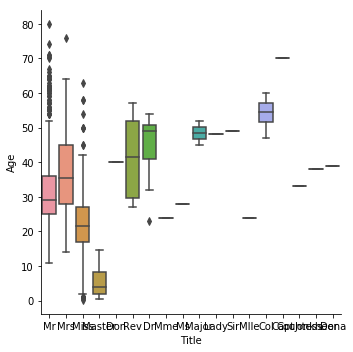

In [43]:
sns.catplot(data=dataset, y='Age', x='Title', kind='box')

Но многие из значений, как я считаю, можно объединить в 5 групп: Aristocratic, Mr, Mrs, Miss и Master, т.к. объединяемые титулы принадлежат фактически одной или родственным группам.

In [44]:
dataset['Title'].replace(["Capt", "Col", "Don", "Dona", "Dr",
                                   "Jonkheer", "Lady", "Major",
                                   "Rev", "Sir", "Countess"], "Aristocratic", inplace=True)
dataset['Title'].replace(['Ms'], 'Mrs', inplace=True)
dataset['Title'].replace(["Mlle", 'Mme'], "Miss", inplace=True)

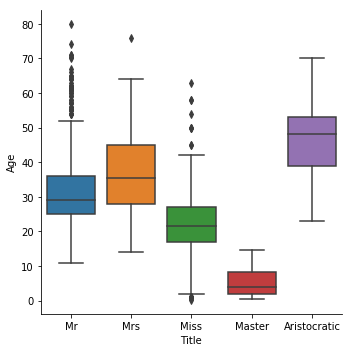

In [45]:
sns.catplot(data=dataset, y='Age', x='Title', kind='box')

Давайте введём такой показатель как Процент выживаемости и посмотрим на его зависимость от групп, которые получились на предыдущем этапе.

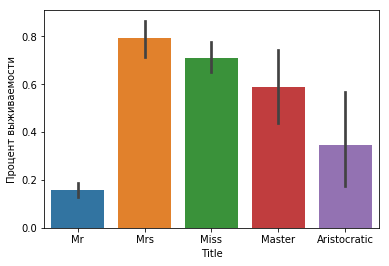

In [46]:
g = sns.barplot(data=dataset, x='Title', y='Survived')
g = g.set_ylabel("Процент выживаемости")

Видим, что самый большой процент выживаемости у женского пола и у мальчиков, а самый низкий - у мужчин.

Что касается признаков SibSp, Parch, можем предположить, что большой размер семьи затрудняет эвакуацию.
Создадим новый признак как сумму SibSp + Parch + 1 (+1 потому что мы считаем самого пассажира частью семьи)

In [47]:
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

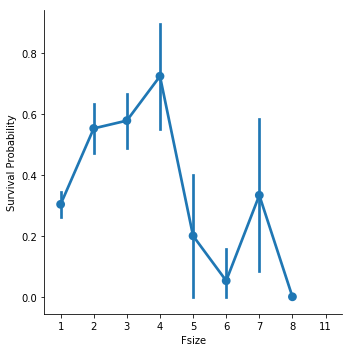

In [52]:
g = sns.catplot(x="Fsize", y="Survived", data = dataset, kind='point')
g = g.set_ylabels("Survival Probability")

Кажется, что размер семьи играет важную роль, вероятность выживания хуже для больших семей.

In [53]:
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1007
Embarked          0
Title             0
Fsize             0
dtype: int64

Как мы могли заметить на графике, распределение цен на билеты Fare немного искажено вбок. Это может повлиять на обуение модели вцелом. Потому стоит масштабировать данные чтобы выровнять распределение. Для этого можно попробовать просто извлечь квадратный корень, или применить логарифмирование, что мы и сделаем.

In [54]:
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

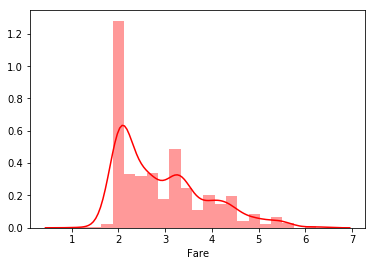

In [55]:
sns.distplot(dataset['Fare'], color='r')

Нетрудно заметить, что после логарифмической трансформации искажение графика распределения заметно исчезло. Это должно позитивно повлиять на обучение.

Конвертируем категориальные переменные в числовые значения.
Удалим признак Name, поскольку мы извлекли всю нужную информацию и создали из неё новый признак Title.
Так же удалим признак Cabin, поскольку подавляющее количество значений пропущено, и заполнить пропуски, как в случае с Age, не получится. 
Удалим столбец PassengerId, поскольку он является несущественным для обучения модели (может создавать лишний шум).
И для упрощения удалим столбец Ticket, т.к. данные представлены в различной форме(буквы, цифры, буквы+цифры) и не совсем очевидно, что с ними можно сделать.

In [56]:
embarked_df = pd.get_dummies(dataset['Embarked'])
sex_df = pd.get_dummies(dataset['Sex'])
dataset = pd.concat([dataset, embarked_df, sex_df], axis=1)

# чтобы не увеличивать лишний раз размерность входных данных и не заполнять таблицу нулями,
# произведем обычную замену для признака Title
le = LabelEncoder()
dataset['Title'] = le.fit_transform(dataset['Title']).astype(np.uint16)
dataset.drop(columns=['Sex', 'Embarked', 'Name', 'Cabin', 'Ticket', 'PassengerId'], inplace=True)

In [57]:
dataset.head()


,Survived,Pclass,Age,SibSp,Parch,Fare,Title,Fsize,C,Q,S,female,male
0,0.0,3,22.0,1,0,1.981001,3,2,0,0,1,0,1
1,1.0,1,38.0,1,0,4.266662,4,2,1,0,0,1,0
2,1.0,3,26.0,0,0,2.070022,2,1,0,0,1,1,0
3,1.0,1,35.0,1,0,3.972177,4,2,0,0,1,1,0
4,0.0,3,35.0,0,0,2.085672,3,1,0,0,1,0,1


### Построение моделей прогнозирования

In [58]:
# разделим датасет на обучающее и тестируемое множества
train = dataset[:len_train].copy()
test = dataset[len_train:].copy()
test.drop(columns=["Survived"], axis = 1, inplace=True)

In [59]:
# разделим обучающее множество на независимые переменные и целевой признак
train["Survived"] = train["Survived"].astype(int)
Y_train = train["Survived"].copy()
X_train = train.drop(labels=["Survived"], axis = 1)


Для сравнения возьмем 10 популярных классификаторов и оценим среднюю точность каждого из них,
используя процедуру перекрестной проверки (kfold cross validation).

* SVC
* Decision Tree
* AdaBoost
* Random Forest
* Extra Trees
* Gradient Boosting
* Multiple layer perceprton (neural network)
* KNN
* Logistic regression
* Linear Discriminant Analysis


In [60]:
kfold = StratifiedKFold(n_splits=10)

In [61]:
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

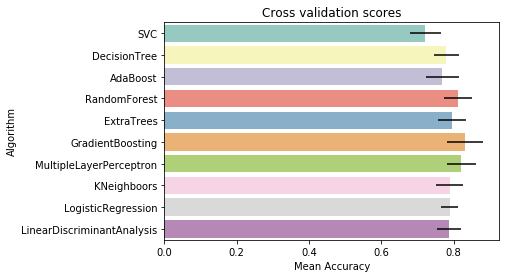

In [62]:
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

Выберем три классификатора с наилучшими результатами: GradientBoosting, MultiLayerPerceptron, RandomForest.

Подберем гиперпараметры для этих моделей, используя grid search optimization.

In [63]:
# подбор гиперпараметров для GradientBoosting
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1]
}
gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsGBC.fit(X_train,Y_train)
GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    6.7s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   33.8s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:  1.1min finished


0.83091164453524

In [64]:
# подбор гипермараметров для RandomForest
RFC = RandomForestClassifier()
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]
}
gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsRFC.fit(X_train, Y_train)
RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   34.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.9min finished


0.8342824310520939

In [65]:
# подбор гиперпараметров для MultiLayerPerceptron
MLP = MLPClassifier()
mlp_param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu', 'identity', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
gsMLP = GridSearchCV(MLP, param_grid = mlp_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsMLP.fit(X_train, Y_train)
MLP_best = gsMLP.best_estimator_

gsMLP.best_score_

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   39.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  5.6min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  7.9min
[Parallel(n_jobs=4)]: Done 960 out of 960 | elapsed:  9.9min finished
/home/vitalii/PycharmProjects/titanic/venv/lib/python3.5/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.8274897854954034

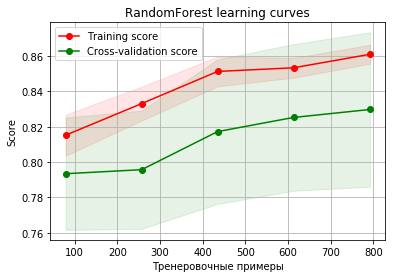

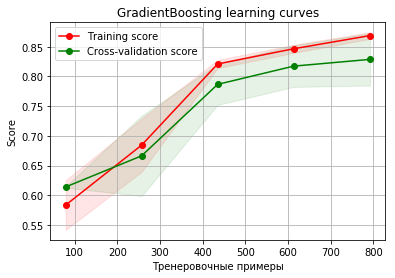

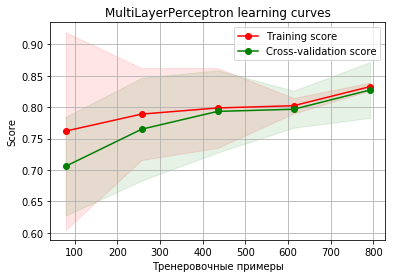

In [68]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=4, train_sizes=np.linspace(.1, 1.0, 5)):
    """Построение кривых обучения и тестирования"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Тренеровочные примеры")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RandomForest learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_, 'GradientBoosting learning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsMLP.best_estimator_, 'MultiLayerPerceptron learning curves', X_train, Y_train, cv=kfold)

Если score обучения и score валидации являются низкими, модель будет недообученна. Если тренировочный score высокий, а score валидации низкий, модель переобучается и в остальном работает хорошо. Низкий score обучения и высокий score валидации обычно невозможны. На графиках выше видно, что хуже всех обстоят дела у многослойного персептрона, лучше - у GradientBoosting.

In [69]:
def create_submission_csv(model):
    """Создание CSV файла с предсказаниями"""
    global test, IDtest
    results = pd.concat([IDtest, pd.Series(model.predict(test), name="Survived")], axis=1)
    results.to_csv('{}_submission.csv'.format(model.__class__.__name__), index=False)

create_submission_csv(RFC_best)
create_submission_csv(GBC_best)
create_submission_csv(MLP_best)

In [ ]:
# построим прогноз из ансамбля моделей на основе голосования с параметром voting='soft'( итоговый ответ 
# объединенного классификатор — это argmax суммы предсказанных вероятностей по двум классам: 1-выжилб 0-погиб)
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('gbc',GBC_best), ('mlp', MLP_best)], voting='soft', n_jobs=4)
votingC = votingC.fit(X_train, Y_train)
create_submission_csv(votingC)